## Comparing signature quality with signature similarity
### For PROGENy benchmark

In [3]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

import os

In [47]:
#check the random distribution of ROC AUCs
results=pd.read_csv('../results/benchmark/progeny/rocaucs/random_dist.csv',sep=',',header=0,index_col=0)
progeny=pd.read_csv('../results/benchmark/progeny/raw/progeny_meta.csv',
                        sep=',',header=0,index_col=0)
progeny=progeny['pathway'].value_counts()
progeny=progeny[results.index]
background=pd.DataFrame(index=results.index,columns=['Mean','Sd','Size'])
background['Mean']=np.mean(results,1)
background['Sd']=np.std(results,1)
background['Size']=progeny

Text(0, 0.5, 'Pathway size\n(# of experiments per PW)')

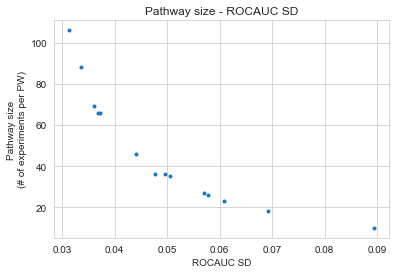

In [48]:
plt.plot(background['Sd'],background['Size'],'.')
plt.title('Pathway size - ROCAUC SD')
plt.xlabel('ROCAUC SD')
plt.ylabel('Pathway size\n(# of experiments per PW)')

In [74]:
#normalise ROCAUCS
fnames=os.listdir('../results/benchmark/progeny/rocaucs/')
fnames.remove('random_dist.csv')
data={}
for fname in fnames:
    data[fname[:-4]]=pd.read_csv('../results/benchmark/progeny/rocaucs/'+fname,sep=',',header=0,index_col=0)
for method in data.keys():
    for pw in background.index:
        data[method].loc[pw,:]=(data[method].loc[pw,:]-0.5)/background.loc[pw,'Sd']
for method in data.keys():
    data[method].to_csv('../results/benchmark/progeny/z_scores/%s.csv' % method, sep=',')

In [552]:
from scipy.stats import spearmanr as scor
from scipy.stats import pearsonr as pcor

def compare_similarity_and_quality(tf,pw,method):
    tf_activity=pd.read_csv('../results/benchmark/progeny/z_scores//%s.csv' % tf, sep=',',header=0,index_col=0).abs().max()
    pw_activity=pd.read_csv('../results/benchmark/progeny/z_scores//%s.csv' % pw, sep=',',header=0,index_col=0).abs().max()
    tf_pw_sim=pd.read_csv('../results/similarity/similarity/%s_%s_%s.csv' % (tf,pw,method),sep=',',
                         header=0,index_col=0)
    tf_sim=np.max(tf_pw_sim,1)[tf_activity.index]
    pw_sim=np.max(tf_pw_sim,0)[pw_activity.index]
    f,axs=plt.subplots(1,2,figsize=(4,2),dpi=300)
    sns.regplot(tf_activity,tf_sim,ax=axs[0],scatter_kws={'s':2})
    sns.regplot(pw_activity,pw_sim,ax=axs[1],scatter_kws={'s':2})
    axs[0].set_ylabel(method + ' with\n' + pw,size=7)
    axs[1].set_ylabel(method + ' with\n' + tf,size=7)
    axs[0].set_xlabel('Gene set quality\n(z score)',size=7)
    axs[1].set_xlabel('Gene set quality\n(z score)',size=7)
    axs[0].set_xticks([5,10])
    axs[0].set_xticklabels([5,10],fontsize=5)
    t=np.max(tf_sim)
    axs[0].set_yticks([t/2,t])
    axs[0].set_yticklabels([str(t/2)[:4],str(t)[:4]],fontsize=5)
    axs[1].set_xticks([5,10])
    axs[1].set_xticklabels([5,10],fontsize=5)
    t=np.max(pw_sim)
    axs[1].set_yticks([t/2,t])
    axs[1].set_yticklabels([str(t/2)[:4],str(t)[:4]],fontsize=5)
    plt.tight_layout()
    print(tf,scor(tf_activity,tf_sim),pcor(tf_activity,tf_sim))
    print(pw,scor(pw_activity,pw_sim),pcor(pw_activity,pw_sim))

dorothea_A SpearmanrResult(correlation=0.02486474369550636, pvalue=0.7657753336499618) (-0.041181681383729796, 0.6216364167280631)
KEGG SpearmanrResult(correlation=0.33453958403362966, pvalue=3.2524543208187875e-06) (0.37814236723797456, 1.1156005161757651e-07)


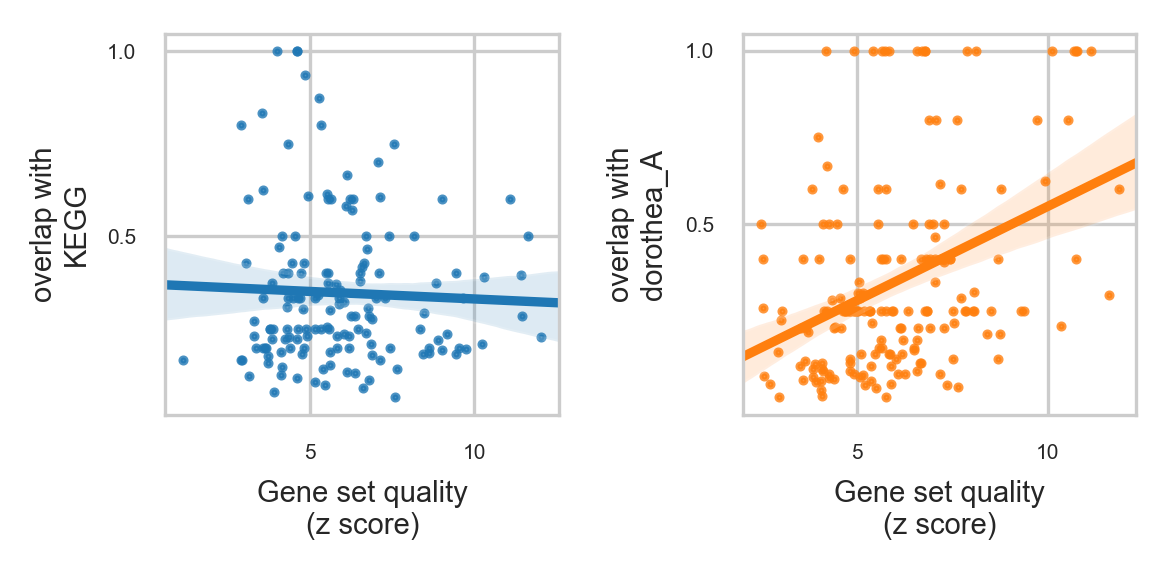

In [567]:
compare_similarity_and_quality('dorothea_A','KEGG','overlap')

In [462]:
tf='dorothea_AB'
tf_activity=pd.read_csv('../results/benchmark/gdsc/partcors/%s.csv' % tf, sep=',',header=0,index_col=0)
tf_activity=(tf_activity.T / tf_activity.std(1)).T.abs().max()

In [529]:
tf_activity=pd.read_csv('../results/benchmark/gdsc/partcors/%s.csv' % 'dorothea_BEST', sep=',',header=0,index_col=0)

In [530]:
tf_activity

,AHRR_E,HAND1_E,IRF6_E,NR4A3_E,ELF2_E,LHX4_E,E4F1_E,BARHL1_E,TBP_C,HES6_E,...,ZNF814_E,ZNF75A_E,DMRT2_E,ZNF221_E,ZFX_C,ZNF140_E,ZNF548_E,HOXB2_E,ZHX3_E,ARID2_C
6,-0.042569,0.010242,0.045432,-0.028138,0.023354,0.016684,-0.011030,0.035300,0.080279,-0.027788,...,0.032615,0.069971,-0.037249,-0.003905,0.025667,0.020240,0.028844,-0.082134,0.077733,0.054036
64,0.037290,0.005781,0.091106,-0.029072,-0.044438,0.049189,0.046825,0.049190,-0.060197,0.122139,...,-0.033347,-0.005368,-0.011921,-0.070406,-0.054200,-0.062485,-0.057013,-0.034423,-0.005893,-0.062501
229,-0.034366,0.014673,-0.057683,0.011576,-0.022153,-0.010059,-0.021631,-0.053229,0.014440,-0.018274,...,-0.059878,-0.068941,-0.004748,0.013298,0.030244,-0.023452,-0.011295,0.062202,0.075699,-0.046690
1024,0.002173,-0.010371,0.140165,-0.074411,0.006169,0.036269,0.047735,0.033297,-0.003233,-0.019004,...,0.109152,0.080929,0.039191,0.087811,-0.012852,0.011364,0.032291,-0.105423,-0.009631,-0.014919
1377,-0.139947,0.054050,-0.326861,0.055150,0.002342,0.025389,0.011546,-0.096941,-0.059024,0.085539,...,-0.018896,0.002778,-0.048554,0.067547,0.044689,-0.047059,0.055287,0.192469,0.120179,-0.004402
53,0.121993,0.091872,0.071483,0.011639,-0.051037,0.050927,0.058274,0.012600,-0.051956,0.040567,...,-0.010219,-0.021423,0.067987,-0.077392,-0.069309,-0.019793,-0.073288,-0.045645,-0.065734,-0.077278
60,0.059407,0.169767,0.056183,0.039377,-0.152743,-0.070302,-0.059845,0.089532,-0.072764,0.005018,...,-0.129737,-0.150651,0.126518,-0.220938,-0.179727,-0.152686,-0.121589,0.052649,0.056088,-0.129868
1009,-0.060452,0.018882,0.022534,-0.004570,0.006092,-0.092762,-0.050030,0.068911,0.086622,-0.023356,...,-0.028124,0.051043,0.018911,-0.006279,-0.011171,0.023587,0.057859,0.034473,0.030898,0.007905
226,0.063772,-0.023392,0.040989,0.087111,-0.113145,-0.073329,0.012899,-0.027224,0.050628,0.066027,...,-0.105012,-0.149210,-0.024363,-0.109482,-0.123094,-0.143935,-0.138454,0.031064,0.088747,-0.111158
301,0.039964,0.031050,-0.049389,0.051878,-0.118215,-0.080519,-0.005955,0.001918,0.018695,0.058653,...,-0.127324,-0.115043,-0.008932,-0.020941,-0.124311,-0.142579,-0.111430,0.107636,0.123969,-0.104478


In [467]:
tf_pw_sim=pd.read_csv('../results/similarity/similarity/%s_%s_%s.csv' % ('dorothea_AB','KEGG','overlap'),sep=',',
                         header=0,index_col=0)

In [466]:
tf_pw_sim

,KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY,KEGG_APOPTOSIS,KEGG_GLYCINE_SERINE_AND_THREONINE_METABOLISM,KEGG_BETA_ALANINE_METABOLISM,KEGG_HEMATOPOIETIC_CELL_LINEAGE,KEGG_VEGF_SIGNALING_PATHWAY,KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_GLOBO_SERIES,KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY,KEGG_THYROID_CANCER,KEGG_GALACTOSE_METABOLISM,...,KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION,KEGG_PHOSPHATIDYLINOSITOL_SIGNALING_SYSTEM,KEGG_FC_EPSILON_RI_SIGNALING_PATHWAY,KEGG_STEROID_BIOSYNTHESIS,KEGG_PENTOSE_PHOSPHATE_PATHWAY,KEGG_PATHOGENIC_ESCHERICHIA_COLI_INFECTION,KEGG_ACUTE_MYELOID_LEUKEMIA,KEGG_RENAL_CELL_CARCINOMA,KEGG_PRION_DISEASES,KEGG_RNA_POLYMERASE
FOXP1,0.006711,0.004000,0.000000,0.000000,0.008032,0.008439,0.000000,0.008475,0.000000,0.000000,...,0.000000,0.021368,0.008333,0.000000,0.000000,0.004525,0.013636,0.013043,0.005076,0.000000
KLF6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MYCN,0.000000,0.009346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020833,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RFXANK,0.000000,0.000000,0.000000,0.000000,0.051546,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
REL,0.019481,0.028571,0.000000,0.000000,0.038462,0.000000,0.000000,0.010638,0.000000,0.000000,...,0.000000,0.000000,0.010204,0.000000,0.000000,0.000000,0.000000,0.000000,0.057692,0.000000
PPARA,0.000000,0.008696,0.000000,0.000000,0.008696,0.009709,0.000000,0.009804,0.000000,0.000000,...,0.014085,0.000000,0.000000,0.000000,0.000000,0.011628,0.000000,0.000000,0.000000,0.000000
PRDM14,0.003106,0.003663,0.000000,0.000000,0.003663,0.003831,0.000000,0.003846,0.009390,0.000000,...,0.000000,0.011583,0.000000,0.000000,0.000000,0.004098,0.004082,0.000000,0.000000,0.000000
RARB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IRF3,0.007143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ATF4,0.005917,0.008333,0.015873,0.000000,0.000000,0.018692,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000
